In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import sys
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
import random
random.seed(2) # Python
np.random.seed(1) #numpy
from tensorflow import set_random_seed
set_random_seed(3) # Tensorflow

In [0]:
root_path = "./drive/My Drive/"
train_path = os.path.join(root_path,'Dataset/training') 
validation_path = os.path.join(root_path,'Dataset/validation')
model_save_path=os.path.join(root_path,'transfer_learning_siamese_model1.h5')

In [0]:




def load_image(path, n = 0):
    X = []
    
    #Load every srud seperately and place that in one tensor
    for student in os.listdir(path):
#         print("Loading student: " + student)
        student_path = os.path.join(path, student)
       
        category_images = []
            
        if not os.path.isdir(student_path):
                continue
            
            #Read evey image with in the directory
        for filename in os.listdir(student_path):
                image_path = os.path.join(student_path, filename)
                image = imageio.imread(image_path)
                width = 105
                height = 105 # keep original height
                dim = (height,width)
 
                # resize image
                image = cv2.resize(image, dim)
                image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                image= np.expand_dims(image, axis=0)
#                 print(image_path)
                #Image preprocessing
                image = image/255
                image = 1 - image
                
                X.append(image)
                
        
    X = np.stack(X)
    return X

In [5]:
print("Loading Training Set")
X = load_image(train_path)
print(X.shape)

Loading Training Set
(1470, 1, 105, 105)


In [6]:
print("Now loading evaluation set")
Y = load_image(validation_path)
print(Y.shape)

Now loading evaluation set
(646, 1, 105, 105)


In [0]:
x_train ,x_test = train_test_split(X, test_size=.20)

In [0]:
 y_train,y_test = train_test_split(Y, test_size=.20)

In [0]:
def get_batch(data, batch_size):
    n_classes, n_examples, h, w = data.shape
    
    pairs = [np.zeros((batch_size, 1, h, w)) for i in range(2)]
    
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    categories = np.random.choice(n_classes, size = (batch_size), replace = False)
    
    for i in range(batch_size):
        category = categories[i]
        
        idx1 = np.random.randint(0, n_examples)
        pairs[0][i,:,:,:] = data[category, idx1].reshape(1, h,w)
        idx2 = np.random.randint(0, n_examples)
        
        if targets[i] == 0:
            category_2 = category
        else:
            category_2 = (category + np.random.randint(1, n_classes)) % n_classes
 
        
        pairs[1][i,:,:,:] = data[category_2, idx2].reshape(1, h, w)
        
    return pairs, targets
        



In [0]:
def generate(data,batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(X,batch_size)
            yield (pairs, targets)    


 

In [0]:
def make_oneshot_task(N,data,language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        n_classes, n_examples, w, h = data.shape
        indices = np.random.randint(0,n_examples,size=(N,))
        categories = np.random.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1 = np.random.randint(0, n_examples)
        ex2 = np.random.randint(0, n_examples)
        # ex1, ex2 = np.random.choice(n_examples,replace=False,size=(0,))
        test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N, 1, w,h)
        support_set = data[categories,indices,:,:]
        support_set[0,:,:] = data[true_category,ex2]
        support_set = support_set.reshape(N, 1, w,h)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    

                   

In [0]:
def test_oneshot(model,N,k,data,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = make_oneshot_task(N,data)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    


In [0]:
def train(model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),)

In [0]:
from keras.models import Model, load_model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l2

from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import time
from keras.optimizers import RMSprop
import pickle

In [0]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Conv2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Conv2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [0]:
#Contrastive Loss
def euclid_dist(input_pair):
    x, y = input_pair
    distance = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
    return distance

def euclid_dist_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = -1 * y_true + 1
    return K.mean((1-y_true) * K.square(y_pred) + y_true *  K.square(K.maximum(margin - y_pred, 0.0)))

def acc(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1)



In [0]:
INIT_WEIGHTS = os.path.join(root_path, 'init_weights.hdf5')
CHECKPOINTED_WEIGHTS = os.path.join(root_path, 'checkpointed_weights.hdf5')

In [18]:
input_dim =(x_train.shape[1:])
base_network = build_base_network(input_dim)
# print(input_dim)
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

# print(base_network)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclid_dist, output_shape=euclid_dist_shape)([feat_vecs_a, feat_vecs_b])
prediction = Dense(1, activation='sigmoid')(distance)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 105, 1..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [19]:

siamese = Model(inputs=[img_a, img_b], outputs=prediction)
    
optimizer = Adam(lr = 0.00006)
    
siamese.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[acc])

siamese.summary()
os.system("rm {}".format(INIT_WEIGHTS))
siamese.save_weights(INIT_WEIGHTS)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           1850174     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]        

In [20]:
#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=1 # interval for printing loss (iterations)
batch_size = 32
n_iter = 100
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 30 #how mahy one-shot tasks to validate on?
best = -1
data_path = "./drive/My Drive/"
weights_path= CHECKPOINTED_WEIGHTS
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=get_batch(x_train,batch_size)
    loss=siamese.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = test_oneshot(siamese,N_way,n_val,y_train,verbose=True)
        if val_acc >= best:
            # print("Current best: {0}, previous best: {1}".format(x_test, best))
            print("Saving weights to: {0} \n".format(weights_path))
            siamese.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {},".format(i,loss))


!
Starting training process!
-------------------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[0.2941236, 0.5]
Time for 1 iterations: 2.2377865314483643
Evaluating model on 30 random 20 way one-shot learning tasks ...
Got an average of 100.0% 20 way one-shot learning accuracy
Saving weights to: ./drive/My Drive/checkpointed_weights.hdf5 

iteration 1, training loss: [0.2941236, 0.5],
[0.28930834, 0.5]
Time for 2 iterations: 7.949418783187866
Evaluating model on 30 random 20 way one-shot learning tasks ...
Got an average of 100.0% 20 way one-shot learning accuracy
Saving weights to: ./drive/My Drive/checkpointed_weights.hdf5 

iteration 2, training loss: [0.28930834, 0.5],
[0.28583717, 0.5]
Time for 3 iterations: 12.586270570755005
Evaluating model on 30 random 20 way one-shot learning tasks ...
Got an average of 100.0% 20 way one-shot learning accuracy
Saving weights to: ./drive/My Drive/checkpointed_weights.hdf5 

it

In [23]:

siamese.load_weights(CHECKPOINTED_WEIGHTS)
for layer in siamese.layers:
    layer.trainable = False
siamese.summary()
siamese.save(model_save_path)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           1850174     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]         

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [26]:
import keras.losses
# keras.losses.custom_loss = 
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model
siamese_net = load_model(model_save_path, custom_objects={'contrastive_loss': contrastive_loss})
siamese_net.compile(loss=contrastive_loss, optimizer='adam', metrics=[acc])

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [38]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,x_test)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 1000
for N in ways:
    val_accs.append(test_oneshot(siamese_net, N,trials, y_test, verbose=True))
    train_accs.append(test_oneshot(siamese_net, N,trials, x_test, verbose=True))
    nn_acc=test_nn_accuracy(N,trials)
    nn_accs.append(nn_acc)
    print("----------------------------------------------------------------------------------------------------------------------------------------------------")
# #plot the accuracy vs num categories for each
# plt.plot(ways, val_accs, "m")
# plt.plot(ways, train_accs, "y")
# plt.plot(ways, nn_accs, "c")

# plt.plot(ways,100.0/ways,"r")
# plt.show()


Evaluating model on 1000 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 1000 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 1000 unique 1 way one-shot learning tasks ...
----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 1000 random 3 way one-shot learning tasks ...
Got an average of 99.7% 3 way one-shot learning accuracy
Evaluating model on 1000 random 3 way one-shot learning tasks ...
Got an average of 100.0% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 1000 unique 3 way one-shot learning tasks ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 1000 random 5 way one-shot learning tasks ...
Got an average of 99.5% 5 way one-shot learning accuracy
Evaluating model on 1000 random 5 way one-shot learning tasks ...
Got an average of 99.1% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 1000 unique 5 way one-shot learning tasks ...
----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 1000 random 7 way one-shot learning tasks ...
Got an average of 99.5% 7 way one-shot learning accuracy
Evaluating model on 1000 random 7 way one-shot learning tasks ...
Got an average of 98.7% 7 way one-shot learning accuracy
Evaluating nearest neighbour on 1000 unique 7 way one-shot learning tasks ...
------------------------------------------------------

In [0]:
with open(os.path.join(root_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

In [0]:
with open(os.path.join(root_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [0]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, _, h , w = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [0]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

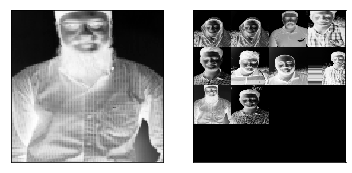

In [103]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(10,X)
plot_oneshot_task(pairs)

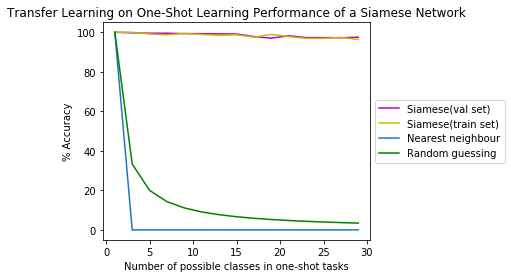

In [77]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")
ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Transfer Learning on One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()



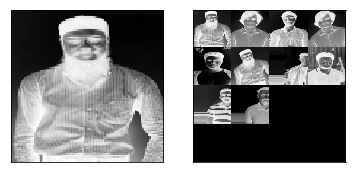

In [101]:
inputs,targets = make_oneshot_task(10, Y)
plot_oneshot_task(inputs)

In [102]:
print(inputs[1].shape)
p=siamese.predict(inputs)
print(p)

(10, 1, 105, 105)
[[0.5013562 ]
 [0.44722316]
 [0.4750369 ]
 [0.447081  ]
 [0.42968953]
 [0.47762498]
 [0.31730753]
 [0.46248716]
 [0.27647546]
 [0.3406664 ]]
